In [1]:
# !unzip /content/Faces.zip

In [2]:
# !unzip /content/Background.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color
import os
from tqdm import tqdm
import joblib
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Preparación de los datos

In [4]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [5]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:02<00:00, 5724.78it/s]


In [6]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

In [7]:
P = len(positive_patches)

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    filename = "Background/"+str(i)+".jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Tamaño de las imágenes de rostros
size = positive_patches[0].shape
print(f'Image size: {size}')

Image size: (64, 64)


In [10]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [11]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:00<00:00, 40.93it/s]


(12800, 64, 64)

In [12]:
N = len(negative_patches)

In [13]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 25633it [00:11, 2314.29it/s]


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(20506, 2916)

In [16]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [17]:
# Guardar el scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [18]:
# Apply PCA to extract eigenfaces

pca = PCA(n_components=500, whiten=True).fit(X_train_std)

In [19]:
# Guardar PCA
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

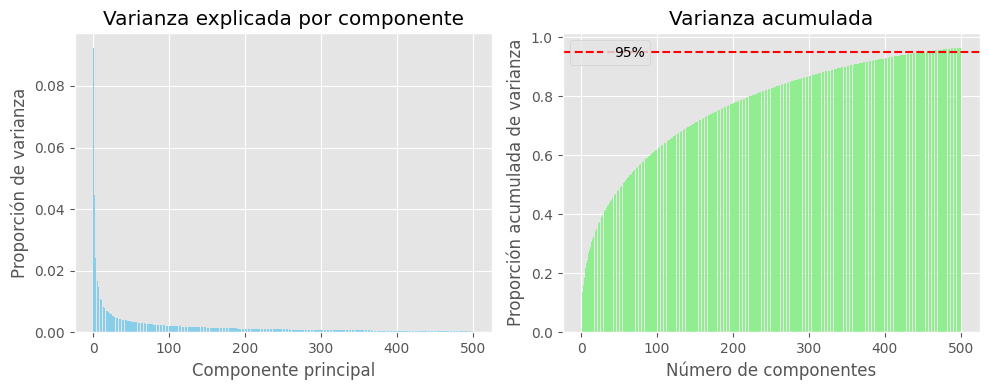

In [20]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

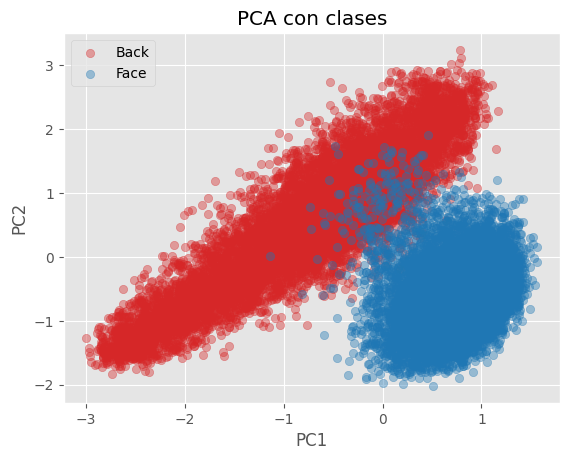

In [21]:
X_train_pca = pca.transform(X_train_std)

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(X_train_pca[y_train == class_value, 0], X_train_pca[y_train == class_value, 1],
                c=colors[class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

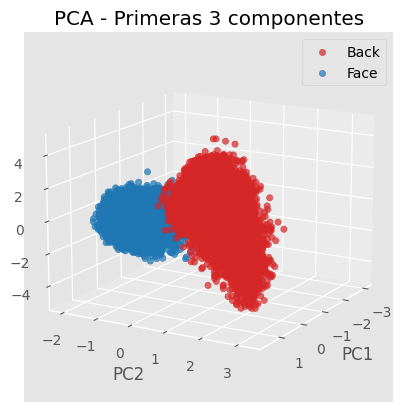

In [22]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()

# Clasificador

In [23]:
model = GaussianNB()

In [24]:
model.fit(X_train_pca, y_train)

GaussianNB()

In [25]:
y_train_pred = model.predict(X_train_pca)

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [27]:
X_val_std = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_std)

In [28]:
y_val_pred = model.predict(X_val_pca)

In [29]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127



In [30]:
# Guardar el modelo
joblib.dump(model, 'modelo_entrenado.joblib')

['modelo_entrenado.joblib']

# Encontrar los mejores hiperparámetros

In [31]:
# pip install optuna

In [42]:
#!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [43]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import xgboost as xgb

In [46]:
# ... existing code ...
def objective(trial):
    # Sugerir hiperparámetros para XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'eval_metric': 'logloss'
    }
    
    # Crear y entrenar el modelo XGBoost con los parámetros sugeridos
    model_trial = xgb.XGBClassifier(**param, n_jobs=-1, random_state=42)
    
    # Evaluar el modelo usando validación cruzada
    cv_scores = cross_val_score(model_trial, X_train_pca, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Retornar el promedio de las puntuaciones de validación cruzada
    return cv_scores.mean()

In [47]:
# Create a study object and optimize
print("Iniciando optimización de hiperparámetros para XGBoost con Optuna...")
study = optuna.create_study(direction='maximize')  # Queremos maximizar el F1-score
study.optimize(objective, n_trials=50)  # Puedes aumentar n_trials para mejores resultados

print("¡Optimización completada!")
print(f"Mejor trial: {study.best_trial.number}")
print(f"Mejor F1-score: {study.best_value:.4f}")
print("Mejores hiperparámetros para XGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-06-22 18:00:08,110] A new study created in memory with name: no-name-067aa5a5-9c5f-4436-8041-eccd5388b3b8


Iniciando optimización de hiperparámetros para XGBoost con Optuna...


[I 2025-06-22 18:00:22,182] Trial 0 finished with value: 0.9919376909690467 and parameters: {'n_estimators': 155, 'max_depth': 9, 'learning_rate': 0.038006102342976196, 'subsample': 0.9904258243847393, 'colsample_bytree': 0.5091814128861919, 'gamma': 1.5503954204144992, 'reg_alpha': 2.8869124309164778, 'reg_lambda': 4.811017994723224}. Best is trial 0 with value: 0.9919376909690467.
[I 2025-06-22 18:00:31,617] Trial 1 finished with value: 0.9873269270977925 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.0011424977460626716, 'subsample': 0.7890757859778823, 'colsample_bytree': 0.5054699274829714, 'gamma': 2.7070068289994125, 'reg_alpha': 0.31834236503126834, 'reg_lambda': 2.1794139969924324}. Best is trial 0 with value: 0.9919376909690467.
[I 2025-06-22 18:00:38,528] Trial 2 finished with value: 0.987178591510005 and parameters: {'n_estimators': 242, 'max_depth': 4, 'learning_rate': 0.0035280398441580557, 'subsample': 0.6767384826897793, 'colsample_bytree': 0.5

¡Optimización completada!
Mejor trial: 41
Mejor F1-score: 0.9936
Mejores hiperparámetros para XGBoost:
  n_estimators: 90
  max_depth: 12
  learning_rate: 0.29700570855152436
  subsample: 0.559334601997334
  colsample_bytree: 0.7679733701856468
  gamma: 0.019147842199662257
  reg_alpha: 2.2123438853979347
  reg_lambda: 4.657179995343226


In [48]:
# Train the final model with the best parameters
best_params = study.best_params

# Usar el PCA ya ajustado y la transformación existente
pca_optimized = pca  # Usamos el PCA original
X_train_pca_optimized = X_train_pca  # Usamos la transformación existente

# Crear y entrenar XGBClassifier con los mejores hiperparámetros
model_optimized = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
model_optimized.fit(X_train_pca_optimized, y_train)

print("¡Modelo XGBoost optimizado entrenado exitosamente!")
print("Mejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


¡Modelo XGBoost optimizado entrenado exitosamente!
Mejores hiperparámetros encontrados:
  n_estimators: 90
  max_depth: 12
  learning_rate: 0.29700570855152436
  subsample: 0.559334601997334
  colsample_bytree: 0.7679733701856468
  gamma: 0.019147842199662257
  reg_alpha: 2.2123438853979347
  reg_lambda: 4.657179995343226


In [49]:
# Evaluate the optimized model on training data
y_train_pred_optimized = model_optimized.predict(X_train_pca_optimized)
print("========== OPTIMIZED MODEL - TRAINING RESULTS ==========")
print(classification_report(y_train, y_train_pred_optimized))


========== OPTIMIZED MODEL - TRAINING RESULTS ==========
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10273
         1.0       1.00      1.00      1.00     10233

    accuracy                           1.00     20506
   macro avg       1.00      1.00      1.00     20506
weighted avg       1.00      1.00      1.00     20506



In [74]:
# # Compare original vs optimized model performance
# print("=== PERFORMANCE COMPARISON ===")
# print("\nOriginal Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred):.4f}")

# print("\nOptimized Model (Validation):")
# print(f"F1-score: {f1_score(y_val, y_val_pred_optimized):.4f}")

# improvement = f1_score(y_val, y_val_pred_optimized) - f1_score(y_val, y_val_pred)
# print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")


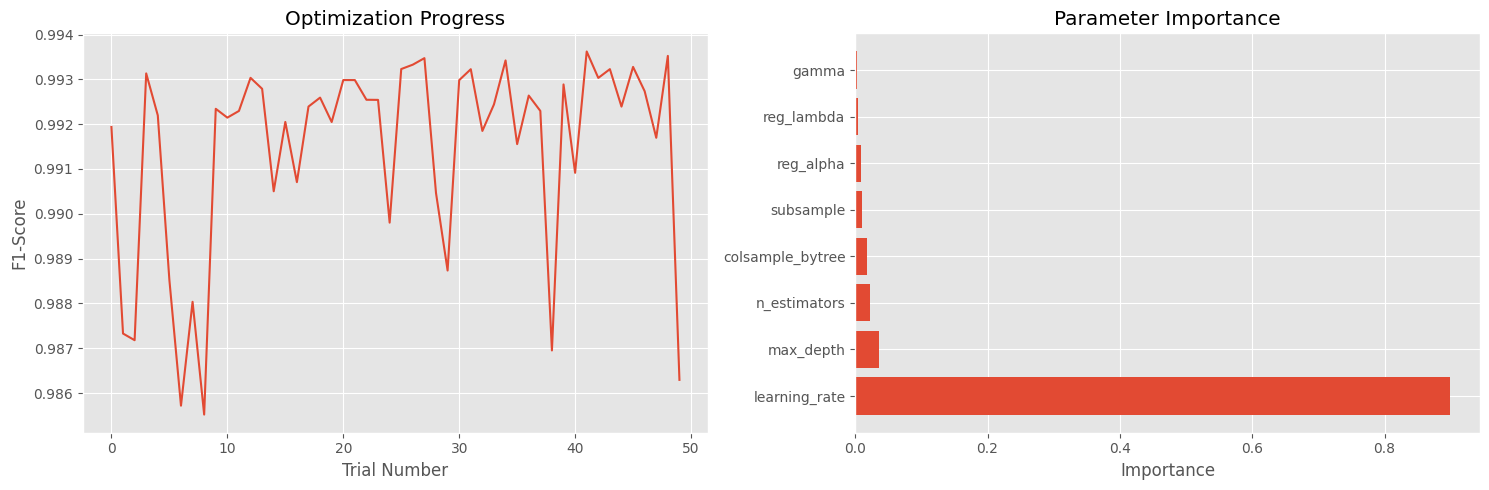

In [50]:
# Visualize optimization history
import matplotlib.pyplot as plt

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot objective values over trials
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'])
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('F1-Score')
ax1.set_title('Optimization Progress')
ax1.grid(True)

# Plot parameter importance (if available)
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax2.barh(params, values)
    ax2.set_xlabel('Importance')
    ax2.set_title('Parameter Importance')
    ax2.grid(True)
except:
    ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Parameter Importance')

plt.tight_layout()
plt.show()


In [53]:
# Save the optimized GaussianNB model
joblib.dump(model_optimized, 'models/xgboost_optimizado.joblib')

print("Optimized XGBoost model saved successfully!")



Optimized XGBoost model saved successfully!


In [52]:
# Evaluate the optimized model on validation data
X_val_pca_optimized = X_val_pca  # Use the existing validation PCA transformation
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))
y_val_pred_optimized = model_optimized.predict(X_val_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred_optimized))


=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2527
         1.0       1.00      0.99      0.99      2600

    accuracy                           0.99      5127
   macro avg       0.99      0.99      0.99      5127
weighted avg       0.99      0.99      0.99      5127

=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2527
         1.0       1.00      0.99      0.99      2600

    accuracy                           0.99      5127
   macro avg       0.99      0.99      0.99      5127
weighted avg       0.99      0.99      0.99      5127



#######

In [54]:
def objective(trial):
    # Hiperparámetro a optimizar
    n_positive_samples = trial.suggest_int('n_positive_samples', 2000, len(positive_patches), step=1000)

    # --- Preparación de datos dentro del objective ---
    # Seleccionar un subconjunto de positive patches
    current_positive_patches = positive_patches[:n_positive_samples]

    # Combinar positive y negative patches para formar el dataset completo
    X_full = np.array([feature.hog(im) for im in chain(current_positive_patches, negative_patches)])
    y_full = np.zeros(len(X_full))
    y_full[:len(current_positive_patches)] = 1

    # Dividir en train y validation
    X_train_trial, X_val_trial, y_train_trial, y_val_trial = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

    # Escalar características
    scaler_trial = StandardScaler()
    X_train_std_trial = scaler_trial.fit_transform(X_train_trial)

    # Aplicar PCA (parámetros fijos)
    pca_trial = PCA(n_components=500, whiten=True)
    X_train_pca_trial = pca_trial.fit_transform(X_train_std_trial)
    # --- Fin preparación de datos ---

    # Hiperparámetros fijos de XGBoost
    xgb_params = {
        'n_estimators': 90,
        'max_depth': 12,
        'learning_rate': 0.29700570855152436,
        'subsample': 0.559334601997334,
        'colsample_bytree': 0.7679733701856468,
        'gamma': 0.019147842199662257,
        'reg_alpha': 2.2123438853979347,
        'reg_lambda': 4.657179995343226,
        'eval_metric': 'logloss'
    }

    # Crear y entrenar XGBClassifier con los hiperparámetros fijos
    model_trial = xgb.XGBClassifier(**xgb_params, n_jobs=-1, random_state=42)

    # Validación cruzada
    cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train_trial,
                                cv=5, scoring='f1', n_jobs=-1)

    # Retornar el promedio del F1-score
    return cv_scores.mean()

In [56]:
print("Starting optimization of n_positive_samples with Optuna and XGBoost...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nOptimization completed!")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best n_positive_samples found:")
print(f"  n_positive_samples: {study.best_params['n_positive_samples']}")
print("\nXGBoost hyperparameters used (fixed):")

[I 2025-06-22 18:20:43,609] A new study created in memory with name: no-name-a91d1ce1-5637-4eff-a81f-6f76b3b383d7


Starting optimization of n_positive_samples with Optuna and XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(
Best trial: 0. Best value: 0.993449:   2%|▏         | 1/50 [00:23<19:31, 23.91s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:21:07,514] Trial 0 finished with value: 0.9934490870715471 and parameters: {'n_positive_samples': 11000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:   4%|▍         | 2/50 [00:44<17:34, 21.97s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:21:28,130] Trial 1 finished with value: 0.9916586706768102 and parameters: {'n_positive_samples': 9000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:   6%|▌         | 3/50 [01:02<15:51, 20.24s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:21:46,301] Trial 2 finished with value: 0.9916559206196119 and parameters: {'n_positive_samples': 7000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:   8%|▊         | 4/50 [01:19<14:31, 18.95s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:22:03,279] Trial 3 finished with value: 0.9915678026002794 and parameters: {'n_positive_samples': 7000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  10%|█         | 5/50 [01:34<13:12, 17.61s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:22:18,522] Trial 4 finished with value: 0.9886892862691713 and parameters: {'n_positive_samples': 4000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  12%|█▏        | 6/50 [01:49<12:14, 16.69s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:22:33,422] Trial 5 finished with value: 0.9857934932280574 and parameters: {'n_positive_samples': 3000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  14%|█▍        | 7/50 [02:12<13:23, 18.69s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:22:56,238] Trial 6 finished with value: 0.9932216180462323 and parameters: {'n_positive_samples': 12000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  16%|█▌        | 8/50 [02:31<13:07, 18.74s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:23:15,075] Trial 7 finished with value: 0.9913812639523473 and parameters: {'n_positive_samples': 7000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  18%|█▊        | 9/50 [02:44<11:33, 16.92s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:23:28,002] Trial 8 finished with value: 0.9830894340562397 and parameters: {'n_positive_samples': 2000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 0. Best value: 0.993449:  20%|██        | 10/50 [03:05<12:02, 18.07s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:23:48,630] Trial 9 finished with value: 0.9915648252637727 and parameters: {'n_positive_samples': 7000}. Best is trial 0 with value: 0.9934490870715471.


Best trial: 10. Best value: 0.993695:  22%|██▏       | 11/50 [03:26<12:21, 19.01s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:24:09,774] Trial 10 finished with value: 0.9936945738877077 and parameters: {'n_positive_samples': 12000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  24%|██▍       | 12/50 [03:48<12:42, 20.06s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:24:32,233] Trial 11 finished with value: 0.9936412626121568 and parameters: {'n_positive_samples': 12000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  26%|██▌       | 13/50 [04:08<12:20, 20.01s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:24:52,134] Trial 12 finished with value: 0.9932045744389395 and parameters: {'n_positive_samples': 10000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  28%|██▊       | 14/50 [04:32<12:42, 21.18s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:25:16,010] Trial 13 finished with value: 0.9934844113879195 and parameters: {'n_positive_samples': 12000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  30%|███       | 15/50 [04:52<12:11, 20.90s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:25:36,259] Trial 14 finished with value: 0.9921502202417886 and parameters: {'n_positive_samples': 9000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  32%|███▏      | 16/50 [05:12<11:40, 20.60s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:25:56,156] Trial 15 finished with value: 0.9930178125555867 and parameters: {'n_positive_samples': 10000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  34%|███▍      | 17/50 [05:29<10:39, 19.37s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:26:12,658] Trial 16 finished with value: 0.989911247446171 and parameters: {'n_positive_samples': 5000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  36%|███▌      | 18/50 [05:52<11:00, 20.63s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:26:36,246] Trial 17 finished with value: 0.9936439152881469 and parameters: {'n_positive_samples': 12000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 10. Best value: 0.993695:  38%|███▊      | 19/50 [06:12<10:32, 20.40s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:26:56,086] Trial 18 finished with value: 0.992888820033939 and parameters: {'n_positive_samples': 10000}. Best is trial 10 with value: 0.9936945738877077.


Best trial: 19. Best value: 0.993792:  40%|████      | 20/50 [06:33<10:16, 20.54s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:27:16,970] Trial 19 finished with value: 0.9937916796292349 and parameters: {'n_positive_samples': 11000}. Best is trial 19 with value: 0.9937916796292349.


Best trial: 19. Best value: 0.993792:  42%|████▏     | 21/50 [06:54<10:01, 20.76s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:27:38,233] Trial 20 finished with value: 0.9925002897543024 and parameters: {'n_positive_samples': 9000}. Best is trial 19 with value: 0.9937916796292349.


Best trial: 19. Best value: 0.993792:  44%|████▍     | 22/50 [07:15<09:41, 20.78s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:27:59,066] Trial 21 finished with value: 0.9931049232887105 and parameters: {'n_positive_samples': 11000}. Best is trial 19 with value: 0.9937916796292349.


Best trial: 19. Best value: 0.993792:  46%|████▌     | 23/50 [07:38<09:40, 21.52s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:28:22,296] Trial 22 finished with value: 0.9932807878487269 and parameters: {'n_positive_samples': 11000}. Best is trial 19 with value: 0.9937916796292349.


Best trial: 23. Best value: 0.993802:  48%|████▊     | 24/50 [08:02<09:40, 22.32s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:28:46,488] Trial 23 finished with value: 0.9938018815623153 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  50%|█████     | 25/50 [08:23<09:04, 21.76s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:29:06,950] Trial 24 finished with value: 0.9935628500235018 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  52%|█████▏    | 26/50 [08:40<08:10, 20.43s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:29:24,270] Trial 25 finished with value: 0.9926451188282719 and parameters: {'n_positive_samples': 8000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  54%|█████▍    | 27/50 [08:57<07:28, 19.48s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:29:41,537] Trial 26 finished with value: 0.9897758319367252 and parameters: {'n_positive_samples': 5000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  56%|█████▌    | 28/50 [09:19<07:20, 20.01s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:30:02,772] Trial 27 finished with value: 0.9931409495848753 and parameters: {'n_positive_samples': 10000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  58%|█████▊    | 29/50 [09:42<07:19, 20.92s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:30:25,832] Trial 28 finished with value: 0.993435622531082 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  60%|██████    | 30/50 [10:03<07:02, 21.13s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:30:47,435] Trial 29 finished with value: 0.9935064707952673 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  62%|██████▏   | 31/50 [10:22<06:27, 20.41s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:31:06,174] Trial 30 finished with value: 0.9923352478566944 and parameters: {'n_positive_samples': 8000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  64%|██████▍   | 32/50 [10:46<06:26, 21.46s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:31:30,067] Trial 31 finished with value: 0.9934291881319375 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  66%|██████▌   | 33/50 [11:10<06:17, 22.21s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:31:54,049] Trial 32 finished with value: 0.9933790063255643 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  68%|██████▊   | 34/50 [11:32<05:53, 22.07s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:32:15,801] Trial 33 finished with value: 0.9933951998465818 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  70%|███████   | 35/50 [11:52<05:24, 21.63s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:32:36,394] Trial 34 finished with value: 0.9932051678339343 and parameters: {'n_positive_samples': 10000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  72%|███████▏  | 36/50 [12:14<05:03, 21.68s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:32:58,177] Trial 35 finished with value: 0.9936947100166382 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  74%|███████▍  | 37/50 [12:37<04:47, 22.15s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:33:21,420] Trial 36 finished with value: 0.9937342876607651 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  76%|███████▌  | 38/50 [12:55<04:09, 20.80s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:33:39,095] Trial 37 finished with value: 0.9926452993033742 and parameters: {'n_positive_samples': 8000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  78%|███████▊  | 39/50 [13:14<03:42, 20.24s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:33:58,022] Trial 38 finished with value: 0.9916558176525753 and parameters: {'n_positive_samples': 9000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  80%|████████  | 40/50 [13:35<03:26, 20.63s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:34:19,547] Trial 39 finished with value: 0.9936779492566 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  82%|████████▏ | 41/50 [13:55<03:02, 20.26s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:34:38,964] Trial 40 finished with value: 0.9918707947529407 and parameters: {'n_positive_samples': 9000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  84%|████████▍ | 42/50 [14:15<02:41, 20.25s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:34:59,170] Trial 41 finished with value: 0.9933922483187267 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  86%|████████▌ | 43/50 [14:36<02:23, 20.48s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:35:20,192] Trial 42 finished with value: 0.9936434227439156 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  88%|████████▊ | 44/50 [14:56<02:01, 20.31s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:35:40,103] Trial 43 finished with value: 0.9931055929373158 and parameters: {'n_positive_samples': 11000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  90%|█████████ | 45/50 [15:19<01:44, 20.99s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:36:02,670] Trial 44 finished with value: 0.9936964226380752 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  92%|█████████▏| 46/50 [15:38<01:21, 20.41s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:36:21,720] Trial 45 finished with value: 0.992763785985251 and parameters: {'n_positive_samples': 10000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  94%|█████████▍| 47/50 [15:59<01:01, 20.56s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:36:42,652] Trial 46 finished with value: 0.993010485363293 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  96%|█████████▌| 48/50 [16:15<00:38, 19.20s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:36:58,663] Trial 47 finished with value: 0.9911134237652034 and parameters: {'n_positive_samples': 6000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802:  98%|█████████▊| 49/50 [16:28<00:17, 17.52s/it]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-22 18:37:12,262] Trial 48 finished with value: 0.9817889610304043 and parameters: {'n_positive_samples': 2000}. Best is trial 23 with value: 0.9938018815623153.


Best trial: 23. Best value: 0.993802: 100%|██████████| 50/50 [16:50<00:00, 20.21s/it]

[I 2025-06-22 18:37:33,939] Trial 49 finished with value: 0.9936419857098386 and parameters: {'n_positive_samples': 12000}. Best is trial 23 with value: 0.9938018815623153.

Optimization completed!
Best trial number: 23
Best F1-score: 0.9938
Best n_positive_samples found:
  n_positive_samples: 12000

XGBoost hyperparameters used (fixed):


In [58]:
study.best_params

{'n_positive_samples': 12000}

In [59]:
# Train the final model with the best n_positive_samples (from Optuna)
best_params = study.best_params

# Re-prepare the data using the best n_positive_samples
final_n_positive_samples = best_params['n_positive_samples']
final_current_positive_patches = positive_patches[:final_n_positive_samples]

# Combine positive and negative patches to form the full dataset
X_final_full = np.array([feature.hog(im) for im in chain(final_current_positive_patches, negative_patches)])
y_final_full = np.zeros(len(X_final_full))
y_final_full[:len(final_current_positive_patches)] = 1

# Split data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final_full, y_final_full, test_size=0.2, random_state=42)

# Scale the features
scaler_final = StandardScaler()
X_train_std_final = scaler_final.fit_transform(X_train_final)
X_val_std_final = scaler_final.transform(X_val_final) # Scale validation data too

# Apply PCA (fixed parameters: 500 components, whiten=True)
pca_final = PCA(n_components=500, whiten=True)
X_train_pca_final = pca_final.fit_transform(X_train_std_final)
X_val_pca_final = pca_final.transform(X_val_std_final) # Transform validation data

# XGBoost hyperparameters (fixed)
xgb_params = {
    'n_estimators': 90,
    'max_depth': 12,
    'learning_rate': 0.29700570855152436,
    'subsample': 0.559334601997334,
    'colsample_bytree': 0.7679733701856468,
    'gamma': 0.019147842199662257,
    'reg_alpha': 2.2123438853979347,
    'reg_lambda': 4.657179995343226,
    'eval_metric': 'logloss'
}

# Create and train XGBoost model with the best n_positive_samples
model_optimized = xgb.XGBClassifier(**xgb_params, n_jobs=-1, random_state=42)
model_optimized.fit(X_train_pca_final, y_train_final)

print("Optimized XGBoost model trained successfully with best parameters!")
print(f"Best n_positive_samples: {best_params['n_positive_samples']}")
print("XGBoost hyperparameters used (fixed):")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")

Optimized XGBoost model trained successfully with best parameters!
Best n_positive_samples: 12000
XGBoost hyperparameters used (fixed):
  n_estimators: 90
  max_depth: 12
  learning_rate: 0.29700570855152436
  subsample: 0.559334601997334
  colsample_bytree: 0.7679733701856468
  gamma: 0.019147842199662257
  reg_alpha: 2.2123438853979347
  reg_lambda: 4.657179995343226
  eval_metric: logloss


In [83]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

In [60]:
joblib.dump(scaler_final ,'models/scaler_optuna.joblib')

['models/scaler_optuna.joblib']

In [61]:
joblib.dump(pca_final ,'models/pca_optuna.joblib')

['models/pca_optuna.joblib']

In [62]:
joblib.dump(model_optimized ,'models/XGBoost_optuna.joblib')

['models/XGBoost_optuna.joblib']